# Preperations


## Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from upsetplot import plot as upsetplot

from src.consts import PATHS


## Constants

In [3]:
base_output_dir = PATHS.PROJECT_DIR / 'output'

In [ ]:
from src.datasets.download_dataset import (
    load_dataset,
    load_knowns,
    load_splitted_counter_fact,
)
from src.types import DATASETS, DatasetArgs


In [12]:
df3 = load_dataset(DatasetArgs(name=DATASETS.COUNTER_FACT, splits="all") )

In [13]:
df3

Dataset({
    features: ['relation', 'relation_prefix', 'relation_suffix', 'prompt', 'relation_id', 'target_false_id', 'target_true_id', 'target_true', 'target_false', 'subject'],
    num_rows: 21919
})

In [26]:
df = pd.DataFrame(load_knowns())

In [27]:
df

,subject,attribute,template,prediction,prompt,relation_id,known_id
0,Vinson Massif,Antarctica,{} is located in the continent,of Antarctica. It is the largest of the three,Vinson Massif is located in the continent of,P30,0
1,Beats Music,Apple,{} is owned by,"Apple, which is also the owner of Beats Elect...",Beats Music is owned by,P127,1
2,Audible.com,Amazon,{} is owned by,"Amazon.com, Inc. or its affiliates.",Audible.com is owned by,P127,2
3,The Big Bang Theory,CBS,{} premieres on,CBS on September 22.<|endoftext|>,The Big Bang Theory premieres on,P449,3
4,MacApp,Apple,"{}, a product created by",Apple to help developers create apps for the ...,"MacApp, a product created by",P178,4
...,...,...,...,...,...,...,...
1204,Kyle Farnsworth,pitcher,{} plays in the position of,"the pitcher, and he's a very good one",Kyle Farnsworth plays in the position of the,P413,1204
1205,Gregory XVI,pope,"{}, whose position is that of","a ""superior"" pope, has been the","Gregory XVI, whose position is that of a ""supe...",P39,1205
1206,My Sister Sam,CBS,{} was originally aired on,CBS in the United States. It was a remake,My Sister Sam was originally aired on,P449,1206
1207,Devonshire Arms,London,{} is located in,"the heart of the city of London, just a",Devonshire Arms is located in the heart of the...,P276,1207


In [ ]:
df2 = pd.DataFrame(load_splitted_counter_fact())

In [29]:
df2

,relation,relation_prefix,relation_suffix,prompt,relation_id,target_false_id,target_true_id,target_true,target_false,subject
0,{} is located in the continent,,{} is located in the continent,Metropolitan France is located in the continent,P30,Q51,Q46,Europe,Antarctica,Metropolitan France
1,{}'s life ended in,,{}'s life ended in,Harold Sakata's life ended in,P20,Q84,Q18094,Honolulu,London,Harold Sakata
2,{}'s profession is an,,{}'s profession is an,Andreas Embirikos's profession is an,P106,Q40348,Q49757,poet,lawyer,Andreas Embirikos
3,The language of {} is,The language of,is,The language of For Eternal Hearts is,P364,Q1568,Q9176,Korean,Hindi,For Eternal Hearts
4,{} is known for performing,,{} is known for performing,Ron Affif is known for performing,P136,Q1344,Q8341,jazz,opera,Ron Affif
...,...,...,...,...,...,...,...,...,...,...
2186,"In {}, an official language is",In,", an official language is","In Oulainen, an official language is",P37,Q150,Q1412,Finnish,French,Oulainen
2187,{} found employment in,,{} found employment in,Kurt Tucholsky found employment in,P937,Q1218,Q64,Berlin,Jerusalem,Kurt Tucholsky
2188,"{}, who works for",,"{}, who works for","John Fellows Akers, who works for",P108,Q9531,Q37156,IBM,BBC,John Fellows Akers
2189,Where is {}? It is located in,Where is,? It is located in,Where is Cannes Film Festival? It is located in,P276,Q25,Q39984,Cannes,Wales,Cannes Film Festival


In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

## Loading Data

### Load Known Files Pre-processed Evaluations
#

In [404]:
known_1000_correct_files_raw = {
    tuple(experiment_path.name.replace('minimal_', '').rsplit("_", maxsplit=1)): pd.read_csv(known_1000_correct_file)
    for experiment_path in base_output_dir.iterdir()
    if (
        known_1000_correct_file := experiment_path
        / "evaluate"
        / "known_1000_correct.csv"
    ).exists()
}

### Preprocess Data

In [405]:
def remove_generation_prefix(df):
    # For some models, the generation is prefixed with the prompt
    return df.apply(
        lambda x: x["model_generation"].removeprefix(
            x["prompt"],
        ),
        axis=1,
    )


def is_correct(target, prediction) -> bool:
    return len(prediction.strip()) > 0 and target.startswith(prediction.strip())


def fix_model_correct(df):
    # Make sure that model_output is at least 1 character long; if empty, it's incorrect
    return df.apply(
        lambda x: is_correct(x["attribute"], x["model_output"]),
        axis=1,
    )


def split_top_outputs(df):
    df = df.copy()
    COL = "model_top_outputs"
    for i in range(len(df[COL].iloc[0])):
        df[f"pred_{i+1}"] = (
            df[COL].apply(lambda x: [item[0] for item in x]).apply(lambda x: x[i])
        )
        df[f"confidence_{i+1}"] = (
            df[COL].apply(lambda x: [item[1] for item in x]).apply(lambda x: x[i])
        )

    return df.drop(columns=COL)


def correct_output_position(df):
    preds = df.pipe(split_top_outputs)
    preds["correct_position"] = np.inf
    for i in range(1, 6):
        preds["correct_position"] = preds.apply(
            lambda x: (
                min(x["correct_position"], i)
                if is_correct(x["attribute"], x[f"pred_{i}"])
                else x["correct_position"]
            ),
            axis=1,
        )
    return preds["correct_position"]

def confidence_diff(df):
    preds = df.pipe(split_top_outputs)

    return preds.apply(
        lambda x: np.inf if x["correct_position"] == np.inf else x["confidence_1"] - x[f"confidence_{int(x['correct_position'])}"],
        axis=1,
    )
    
known_1000_correct_files = {
    experiment_name: (
        df.assign(
            **{
                "model_output": lambda df: df["model_output"].fillna(""),
                "model_top_outputs": lambda df: df["model_top_outputs"].apply(ast.literal_eval),
            }
        ).assign(
            **{
                "model_generation": remove_generation_prefix,
                "model_correct": fix_model_correct,
                "correct_position": correct_output_position,
                'confidence_diff': confidence_diff,
            }
        )
        .assign(
            **{
                "any_correct": lambda df: df["correct_position"] != np.inf,
            }
        )
    )
    for experiment_name, df in sorted(known_1000_correct_files_raw.items())
}


In [406]:
model_names = ['_'.join(x) for x in known_1000_correct_files.keys()]
model_names

['llama2_7b',
 'llama3.2_1B',
 'llama3.2_3B',
 'mamba1_130M',
 'mamba1_2.8B',
 'mamba2_130M',
 'mamba2_2.7B']

In [407]:
# Show keys of the files
print(known_1000_correct_files[next(iter(known_1000_correct_files))].keys())

print(known_1000_correct_files.keys())

Index(['known_id', 'subject', 'attribute', 'template', 'prediction', 'prompt',
       'relation_id', 'model_correct', 'model_top_output_confidence',
       'model_top_outputs', 'model_generation', 'model_output',
       'correct_position', 'confidence_diff', 'any_correct'],
      dtype='object')
dict_keys([('llama2', '7b'), ('llama3.2', '1B'), ('llama3.2', '3B'), ('mamba1', '130M'), ('mamba1', '2.8B'), ('mamba2', '130M'), ('mamba2', '2.7B')])


In [408]:
# Sort known_1000_correct_files by experiment name
per_model_stats_dict = []

# Print experiment details in a hierarchical format
current_arch = None
for (arch_name, size), df in known_1000_correct_files.items():
    df_correct = df[df["any_correct"]]
    position_value_counts = df_correct["correct_position"].value_counts() / len(df)
    per_model_stats_dict.append({
        "arch_name": arch_name,
        "size": size,
        "accuracy": f"{df['model_correct'].mean():.2%}",
        "accuracy_any_correct": f"{df['any_correct'].mean():.2%}",
        'mean_confidence_diff': f"{df_correct['confidence_diff'].mean(): .2e}",
        'mean_correct_position': f"{df_correct['correct_position'].mean():.2f}",
        'mean_correct_top_output_confidence': f"{df_correct['model_top_output_confidence'].mean():.2f}",
        ** {
            f"correct_position_{int(position)}": f"{count:.2%}" 
            for position, count in position_value_counts.items()
        }
    })
    
per_model_stats_df = (
    pd.DataFrame(per_model_stats_dict)
)
per_model_stats_df

,arch_name,size,accuracy,accuracy_any_correct,mean_confidence_diff,mean_correct_position,mean_correct_top_output_confidence,correct_position_1,correct_position_2,correct_position_3,correct_position_4,correct_position_5
0,llama2,7b,71.38%,92.80%,3.82e-02,1.39,0.51,71.38%,12.32%,4.96%,2.73%,1.41%
1,llama3.2,1B,68.82%,94.21%,3.58e-02,1.45,0.42,68.82%,14.56%,6.70%,2.23%,1.90%
2,llama3.2,3B,69.89%,93.38%,3.62e-02,1.42,0.49,69.89%,14.23%,4.22%,3.39%,1.65%
3,mamba1,130M,39.29%,73.86%,4.01e-02,1.91,0.19,39.29%,15.47%,9.68%,5.62%,3.80%
4,mamba1,2.8B,69.31%,91.81%,2.55e-02,1.42,0.40,69.31%,12.41%,5.96%,2.07%,2.07%
5,mamba2,130M,33.09%,73.04%,4.63e-02,1.99,0.18,33.09%,21.75%,8.52%,5.46%,4.22%
6,mamba2,2.7B,67.33%,92.97%,2.52e-02,1.47,0.38,67.33%,14.06%,6.87%,2.98%,1.74%


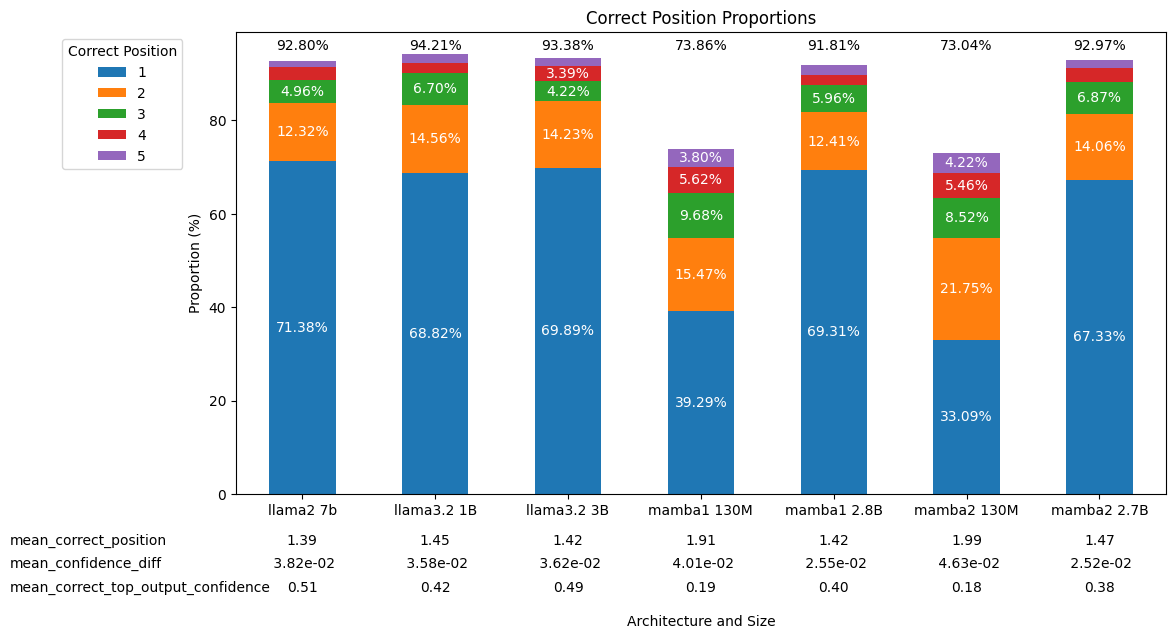

In [411]:
def plot_correct_position_proportions(
    df,
    additional_info_cols=[
        "mean_correct_position",
        "mean_confidence_diff",
        "mean_correct_top_output_confidence",
    ],
):
    rename_col = lambda col: col.replace("correct_position_", "")
    correct_position_cols = [
        col for col in df.columns if col.startswith("correct_position_")
    ]

    correct_position_df = df.assign(
        **{
            rename_col(col): df[col].apply(lambda x: float(x.rstrip("%")))
            for col in correct_position_cols
        }
    ).melt(
        id_vars=["arch_name", "size"],
        value_vars=map(rename_col, correct_position_cols),
        var_name="correct_position",
        value_name="proportion",
    )

    correct_position_df["arch_size"] = (
        correct_position_df["arch_name"] + " " + correct_position_df["size"]
    )

    # Pivot the data to make it suitable for a stacked bar plot
    pivot_df = correct_position_df.pivot_table(
        index=["arch_size"], columns="correct_position", values="proportion"
    )

    # Plotting the stacked bar plot
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(12, 6))
    plt.title("Correct Position Proportions")

    plt.xlabel("Architecture and Size", labelpad=10 + 20 * len(additional_info_cols))
    plt.ylabel("Proportion (%)")
    plt.xticks(rotation=0)
    plt.legend(title="Correct Position", bbox_to_anchor=(-0.05, 1), loc="upper right")

    n_bars = len(pivot_df)
    height = {i: 0 for i in range(n_bars)}
    # Adding total amount on top of each bar
    for idx, bar in enumerate(ax.patches):
        bar_i = idx % n_bars
        position_i = idx // n_bars
        if bar.get_height() > 3:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height[bar_i] + bar.get_height() / 2,
                f"{pivot_df.iloc[bar_i, position_i]:.2f}%",
                fontsize=10,
                ha="center",
                va="center",
                color="white",
            )

        height[bar_i] += bar.get_height()

    for i, col in enumerate(additional_info_cols):
        ax.text(
            -2.2,
            -10 - i * 5,
            col,
            fontsize=10,
            ha="left",
            va="center",
            color="black",
        )

    # Adding summary on each model
    for i in range(n_bars):
        bar_location = ax.patches[i].get_x() + ax.patches[i].get_width() / 2
        model_stats = df.iloc[i]

        ax.text(
            bar_location,
            96,
            model_stats["accuracy_any_correct"],
            fontsize=10,
            ha="center",
            va="center",
            color="black",
        )

        for j, col in enumerate(additional_info_cols):
            ax.text(
                bar_location,
                -10 - j * 5,
                model_stats[col],
                fontsize=10,
                ha="center",
                va="center",
                color="black",
            )

    # plt.tight_layout()
    plt.show()


plot_correct_position_proportions(per_model_stats_df)

## Combining Data
#

In [412]:
# Predefined constants for column names
INDEX_COL = "known_id"
TOTAL_CORRECT_COL = "total_correct"
AGGREEMENT_TYPE_COL = "agreement_type"
MODEL_CORRECT_COL = "model_correct"
INDEX_COLUMNS = ["arch_name", "size"]
PER_MODEL_COLS = [
    MODEL_CORRECT_COL,
    "model_output",
    "model_top_output_confidence",
    "model_generation",
    "model_top_outputs",
    'correct_position',
    'confidence_diff',
    'any_correct',
]
SHARE_COLS = [col for col in df.columns if col not in PER_MODEL_COLS + [INDEX_COL]]

# Processing the data using pipes
result = (
    pd.concat(
        [
            df.assign(arch_name=name[0], size=name[1])
            for name, df in known_1000_correct_files.items()
        ]
    )
    .set_index(INDEX_COL)
    .pipe(
        lambda df: (
            pd.concat(
                [
                    df[PER_MODEL_COLS + INDEX_COLUMNS]
                    .set_index(INDEX_COLUMNS, append=True)
                    .unstack(level=[-2, -1]),
                    df[SHARE_COLS].drop_duplicates().sort_index(),
                ],
                axis=1,
            )
        )
    )
    .pipe(
        lambda df: df.assign(
            **{
                TOTAL_CORRECT_COL: df[
                    [col for col in df.columns if col[0] == MODEL_CORRECT_COL]
                ].sum(axis=1),
                'total_any_correct': df[
                    [col for col in df.columns if col[0] == 'any_correct']
                ].sum(axis=1),
                AGGREEMENT_TYPE_COL: (
                    df[[col for col in df.columns if col[0] == MODEL_CORRECT_COL]]
                    .astype(int)
                    .apply(lambda x: "".join(x.astype(str)), axis=1)
                ),
                'any_correct_agreement_type': (
                    df[[col for col in df.columns if col[0] == 'any_correct']]
                    .astype(int)
                    .apply(lambda x: "".join(x.astype(str)), axis=1)
                ),
            }
        )
    )
)

# Experiments

## Experiment 1 - Value Counts

### Experiment 1.1 - Value Counts for Total Correct

In [413]:
# Print value counts for total_correct
(
    result[TOTAL_CORRECT_COL]
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")
)


total_correct
5    23.82%
6    16.79%
7    13.98%
4    12.99%
3     8.52%
2     8.27%
0     8.27%
1     7.36%
Name: proportion, dtype: object

In [414]:
# Print value counts for total_correct
(
    result['total_any_correct']
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")
)


total_any_correct
7    59.14%
6    16.05%
5    14.97%
4     4.30%
3     1.82%
2     1.65%
0     1.08%
1     0.99%
Name: proportion, dtype: object

### Experiment 1.2 - Agreement Type Value Counts
#
In this experiment, we will look at the value counts of the agreement types.
Agreement type is a string that encodes which models agreed on a correct prediction.
#

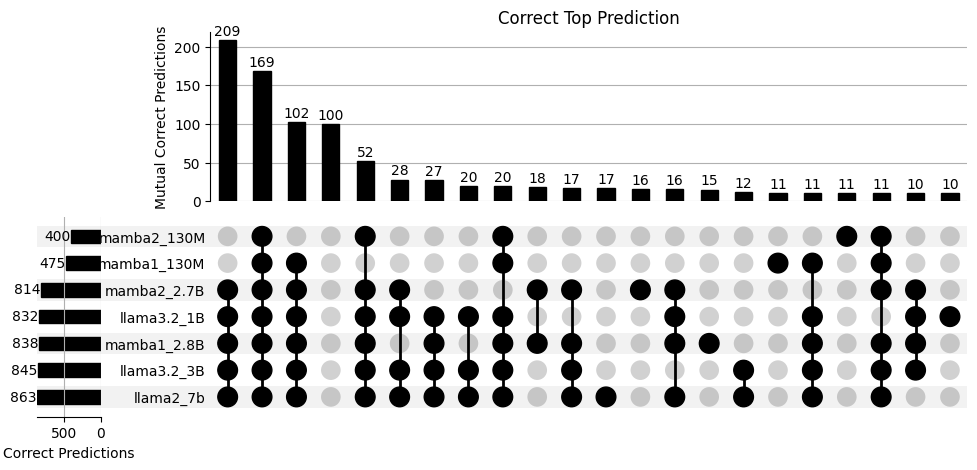

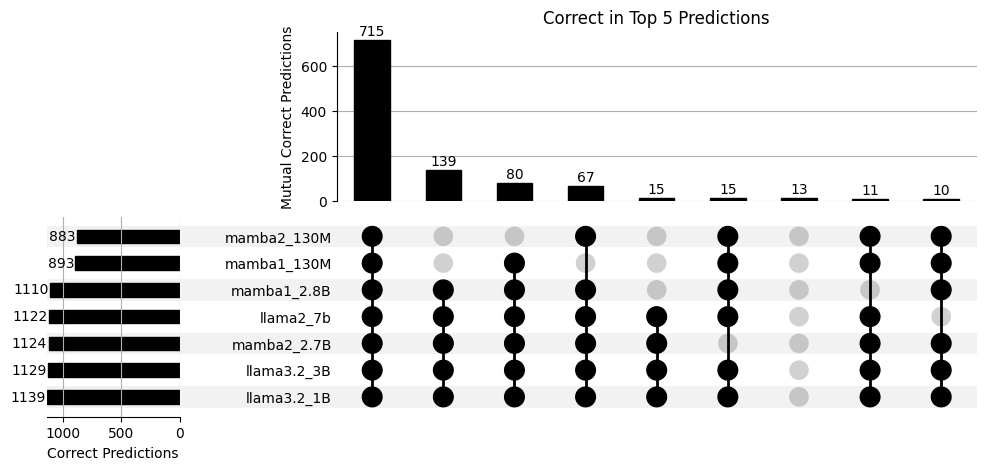

In [420]:
def plot_upset(result, agreement_type_col, title, min_subset_size=10):
    res = (
        result[agreement_type_col]
        .reset_index()
        .assign(**{
            model: lambda df, model=model, i=i: result[agreement_type_col].str[i] == '1'
            for i, model in enumerate(model_names)
        })
        .groupby(model_names)['known_id'].count()
    )
    
    fig = plt.figure(figsize=(12, 5))
    
    upset = upsetplot(
        res,
        fig=fig,
        orientation='horizontal',
        sort_by='cardinality',
        facecolor='black',
        show_counts=True, 
        min_subset_size=min_subset_size,
        element_size=None,
    )

    upset["intersections"].set_ylabel("Mutual Correct Predictions")
    upset["totals"].set_xlabel("Correct Predictions")
    
    plt.title(title)
    plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_upset(result, AGGREEMENT_TYPE_COL, 'Correct Top Prediction')
    plot_upset(result, 'any_correct_agreement_type', 'Correct in Top 5 Predictions')

### Examples of Agreement Type Mistakes
#

In [422]:
agreement_type_example = '1110000'
i_example = 2

# example = result[result[AGGREEMENT_TYPE_COL] == agreement_type_example].iloc[[i_example]]
example = result[result['any_correct_agreement_type'] == agreement_type_example].iloc[[i_example]]


indexed_columns = [
    col for col in example.columns
    if isinstance(col, tuple)
]

# Print shared_columns
display(example.drop(columns=indexed_columns))

print('-'*50)

(
    example[indexed_columns]
    .melt(var_name='variable', value_name='value')
    .assign(col=lambda df_: df_['variable'].apply(lambda x: x[0]), 
            arch_name=lambda df_: df_['variable'].apply(lambda x: x[1]),
            size=lambda df_: df_['variable'].apply(lambda x: x[2]))
    .drop(columns=['variable'])
    .pivot(index=INDEX_COLUMNS, columns='col', values='value')
    .drop(columns=['model_output', 'model_top_output_confidence'])
    .pipe(split_top_outputs)
)


,subject,attribute,template,prediction,prompt,relation_id,total_correct,total_any_correct,agreement_type,any_correct_agreement_type
known_id,,,,,,,,,,
563,Abbasid Caliphate,Baghdad,The capital city of {} is,Baghdad.\n\nThe capital city of Abbasid,The capital city of Abbasid Caliphate is,P36,2,3,1100000,1110000


--------------------------------------------------


col            any_correct confidence_diff correct_position model_correct  \
arch_name size                                                              
llama2    7b          True             0.0              1.0          True   
llama3.2  1B          True             0.0              1.0          True   
          3B          True        0.139669              4.0         False   
mamba1    130M       False             inf              inf         False   
          2.8B       False             inf              inf         False   
mamba2    130M       False             inf              inf         False   
          2.7B       False             inf              inf         False   

col                          model_generation    pred_1  confidence_1  \
arch_name size                                                          
llama2    7b                     Baghdad. The       Bag      0.128427   
llama3.2  1B               Baghdad. It is the   Baghdad      0.096816   
          3B        located in the modern-day   located      0.188142   
mamba1    130M   located in the southern part   located      0.220824   
          2.8B        the largest city in the       the      0.105435   
mamba2    130M            a city of the Abbas         a      0.111162   
          2.7B        the largest city in the       the      0.113903   

col               pred_2  confidence_2     pred_3  confidence_3    pred_4  \
arch_name size                                                              
llama2    7b         the      0.085148    located      0.080663       now   
llama3.2  1B     located      0.077780      known      0.057987       the   
          3B         the      0.072185   situated      0.056028   Baghdad   
mamba1    130M       the      0.072253   situated      0.060370        in   
          2.8B       now      0.048391          a      0.045540     known   
mamba2    130M       the      0.071817        one      0.043964      home   
          2.7B         a      0.111833        now      0.060769   located   

col             confidence_4   pred_5  confidence_5  
arch_name size                                       
llama2    7b        0.065282        a      0.047513  
llama3.2  1B        0.056540      now      0.044569  
          3B        0.048473        a      0.047888  
mamba1    130M      0.057919        a      0.055125  
          2.8B      0.042323   called      0.039138  
mamba2    130M      0.041776      now      0.033411  
          2.7B      0.050198      one      0.046713

## Experiment 2 - Relation ID Interactions
#
### Value Counts for Relation ID
#

In [423]:
# Value counts for relation_id
result['relation_id'].value_counts().tail(10)


relation_id
P131     28
P413     28
P740     26
P1303    26
P136     25
P463     20
P1412    19
P106     16
P138      9
P190      1
Name: count, dtype: int64

### Aggregated Statistics for Relation ID
#

In [430]:
# Aggregated statistics for relation_id
# Only keep relation_ids that appear at least 25 times, then get top 100 per id
top_relation_ids = (
    result
    .pipe(lambda df: df[df['relation_id'].map(df['relation_id'].value_counts()) >= 25])
    .groupby('relation_id')[AGGREEMENT_TYPE_COL]
    .value_counts()
    .groupby(level=0)
    .head(100)
    .unstack(level=0)
)

# Display aggregated statistics
display(top_relation_ids)


relation_id,P101,P103,P108,P127,P1303,P131,P136,P140,P159,P17,P176,P178,P19,P20,P27,P276,P30,P36,P364,P37,P39,P407,P413,P449,P495,P641,P740,P937
agreement_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000000,6.0,NaN,1.0,2.0,3.0,7.0,7.0,NaN,1.0,1.0,5.0,4.0,4.0,4.0,2.0,3.0,NaN,1.0,1.0,2.0,11.0,1.0,3.0,4.0,NaN,2.0,7.0,4.0
0000001,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,3.0,NaN,2.0
0000010,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
0000011,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000100,2.0,NaN,NaN,NaN,1.0,2.0,1.0,NaN,NaN,NaN,1.0,NaN,1.0,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1111100,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1111101,1.0,3.0,2.0,6.0,3.0,1.0,NaN,10.0,3.0,7.0,3.0,8.0,NaN,1.0,7.0,2.0,9.0,4.0,7.0,8.0,2.0,3.0,3.0,1.0,NaN,4.0,2.0,1.0


### Visualizing - Heatmap of Relation IDs
#